**Exercice : Un GAN conditionnel**

Dans cet exercice, il s'agit d'implémenter un Wasserstein-GAN conditionnel. Les aspects théoriques sont laissés de côté: le but est seulement de construire la boucle d'apprentissage.\
Le contexte est le suivant: on se donne un jeu d'images représentatives d'un domaine $\mathcal{D}$.\
Le GAN classique permet de générer de nouvelles images de $\mathcal{D}$. Dans cet exercice, nous allons générer des images compatibles avec une liste de valeurs de pixels données a priori.

Les cellules suivantes permettent de visualiser le jeu disponible.

In [ ]:
# Imports nécessaires
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np

In [ ]:
# Liens valable jusqu'au 17/01/2024:
# data à charger:
! wget https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
! tar xvf L7R8MLxtfzG_NwC5CzNnTSt
! rm L7R8MLxtfzG_NwC5CzNnTSt
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
from utile_BE import *

Mounted at /content/drive


In [ ]:
!nvidia-smi

In [ ]:
dens_obs = 0.005

In [ ]:
x , y , z = gen_condDCGAN(6,dens_obs)

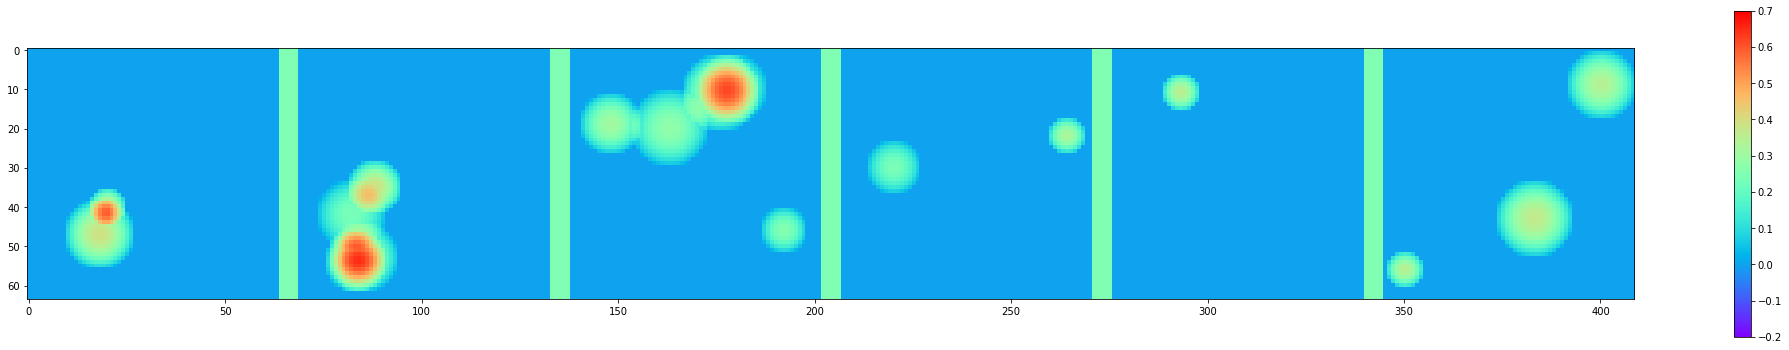

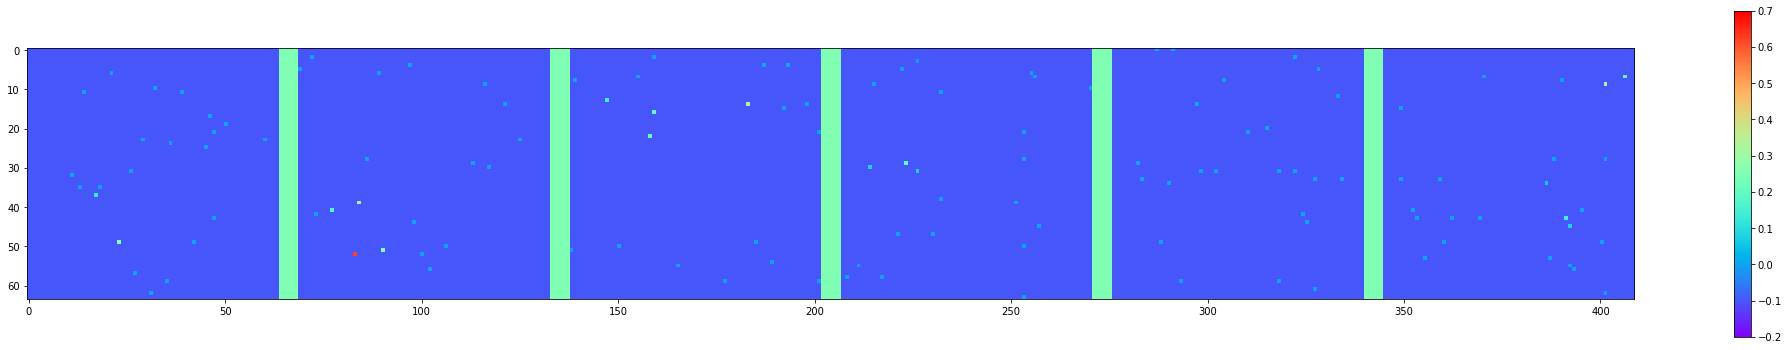

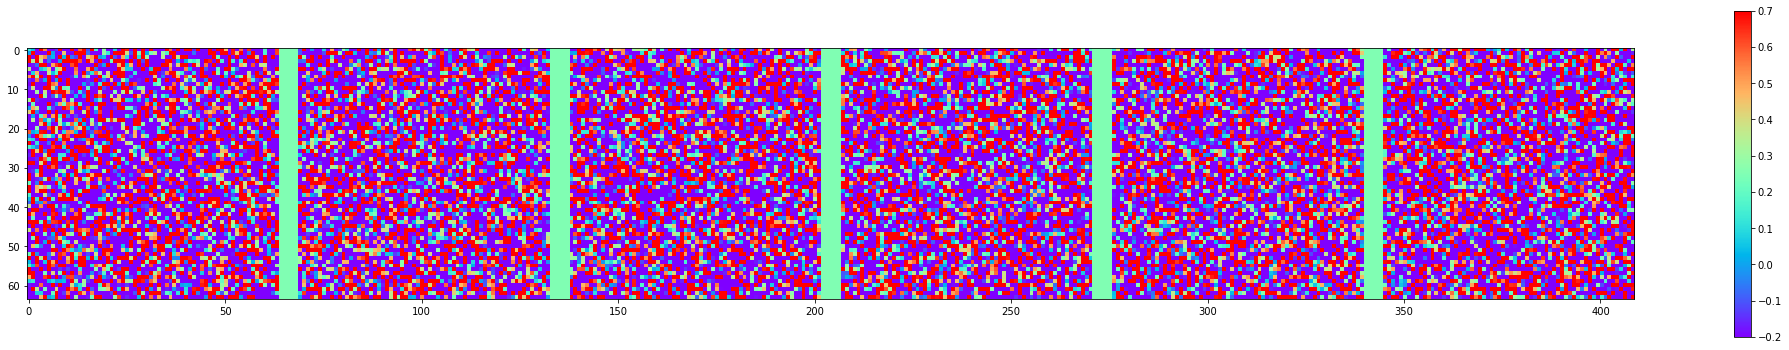

In [ ]:
# images complètes xi
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=-0.2,max_scale=0.7)

# images fragmentaires yi: quelques pixels de xi prélevées au hasard
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=-0.2,max_scale=0.7)

# zi : échantillon d'un vecteur gaussien centré réduit
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=-0.2,max_scale=0.7)


La première ligne contient un échantillon d'images complètes $x^i$. Ces images représente un champ scalaire à valeurs positives ou nulles.

Pour former les images fragmentaires $y^i$ (seconde ligne d'image), on a sélectionné au hasard 0.5% des pixels de chaque $x^i$, dont on a conservé les valeurs. Les valeurs de tous les autres pixels ont été fixées à -0.1.\
A considérer les $x^i$ (resp. $y^i$) comme l'échantillon d'une variable aléatoire $X$ (resp. $Y$), le but de l'exercice peut se reformuler ainsi: nous allons tenter d'échantilloner la loi $\mathcal{L}_{X|Y}$.

**Q1** Décrire brièvement le GAN classique. De combien de réseaux est-il constitué? Quels sont leur rôles respectifs ?

Voir TP3.

**Q2** Ici, pour le générateur $G$, nous utilisons un FCN. Dans le GAN classique, les entrées sont des réalisations d'un vecteur gaussien centré réduit ($z_i$).\
Pour pouvoir prendre en compte le conditionnement par les $x_i$, $G$ doit prendre en entrée les $z_i$ et les $x_i$ (on les concaténera).\
Justifier que, de son côté, le discriminateur doit prendre en entrée les $G(z_i)$ et les $x_i$.\
Compléter la cellule suivante en conséquence.

In [ ]:
nc = 2
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 3, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(ndf * 8 * 4 * 4 , 1),
#            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
ndf = 32
n_channels = 2
n_classes = 1
size = 16

# les classes UNet et Discriminator sont codées dans utile_BE
netG = UNet(n_channels, n_classes, size).cuda()
netD = Discriminator().cuda()

**Q4** En vous inspirant de la correction du TP3, compléter la boucle d'apprentissage et la faire tourner sur dix époques:

In [ ]:
# Paramétrage de la SGD
batch_size = 128
num_batches_generator = 200
num_epochs = 10

# Paramètres de l'optimizer
lr = 0.0005
beta1 = 0. # inertie de la SGD

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
real_label = 1.
fake_label = 0.

In [ ]:
# Pour garder les traces des images générées à partir d'un échantillon de $z_i$ fixé:
fixed_x , fixed_y , fixed_z = gen_condDCGAN(8, p = dens_obs)

# Entrée fixe fu générateur:
fixed_yz = torch.cat((fixed_y,fixed_z), dim=1).cuda()

# Listes
img_list = []
G_losses = []
D_losses = []

# Autres hyper-paramètres
n_critic = 5
clip = 0.01

In [ ]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i in range(num_batches_generator):

        ############################
        # (1) maximisation de log(D(x)) + log(1 - D(G(z)))
        ###########################
        netG.train()
        # Ici, on procède à plusieurs (n_critic) étapes d'optimisation
        # du discriminateur.
        for j in range(n_critic):

            x , y , z = gen_condDCGAN(batch_size, p = dens_obs)
            x = x.cuda()
            y = y.cuda()
            z = z.cuda()

            netD.zero_grad()

            xy = torch.cat((x,y), dim = 1)
            yz = torch.cat((y,z), dim = 1)

            output_xy = netD(xy)

            fake = netG(yz)
            fake = fake.detach()
            fakey = torch.cat((fake,y),dim=1)
            output_fakey = netD(fakey)

            # régularisation par gradient penalty
            gradient_penalty = calculate_gradient_penalty(netD,
                                                              xy.data,
                                                              fakey.data)
            # calcul de l'erreur du discriminateur:
            errD = output_fakey.mean() - output_xy.mean() + 10 * gradient_penalty
            errD.backward()

            optimizerD.step()


        ############################
        # Maximisation de log(D(G(z)))
        ###########################
        netG.zero_grad()

        fake = netG(yz)
        fakey = torch.cat((fake,y),dim=1)
        output_fakey = netD(fakey)
        errG = - output_fakey.mean()
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Enregistrement des losses
        G_losses.append(errG.item())
        D_losses.append(-errD.item())


    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_yz.cuda()).detach().cpu()

    img_list.append(fake)






Starting Training Loop...
[1/10][0/200]	Loss_D: 6.9219
[1/10][50/200]	Loss_D: -2.5962
[1/10][100/200]	Loss_D: -0.8682
[1/10][150/200]	Loss_D: -0.4490
[2/10][0/200]	Loss_D: -0.4286
[2/10][50/200]	Loss_D: -0.2343
[2/10][100/200]	Loss_D: -0.5214
[2/10][150/200]	Loss_D: 0.1555
[3/10][0/200]	Loss_D: -0.1740
[3/10][50/200]	Loss_D: 0.0206
[3/10][100/200]	Loss_D: 0.0168
[3/10][150/200]	Loss_D: -0.0452
[4/10][0/200]	Loss_D: -0.0716
[4/10][50/200]	Loss_D: -0.1306
[4/10][100/200]	Loss_D: 0.0067
[4/10][150/200]	Loss_D: 0.0464
[5/10][0/200]	Loss_D: 0.0052
[5/10][50/200]	Loss_D: -0.0286
[5/10][100/200]	Loss_D: -0.0320
[5/10][150/200]	Loss_D: -0.0347
[6/10][0/200]	Loss_D: -0.0389
[6/10][50/200]	Loss_D: -0.0746
[6/10][100/200]	Loss_D: -0.0662
[6/10][150/200]	Loss_D: -0.0570
[7/10][0/200]	Loss_D: -0.0405
[7/10][50/200]	Loss_D: 0.0301
[7/10][100/200]	Loss_D: -0.0421
[7/10][150/200]	Loss_D: 0.0246
[8/10][0/200]	Loss_D: -0.0215
[8/10][50/200]	Loss_D: -0.0384
[8/10][100/200]	Loss_D: -0.0082
[8/10][150/200]

**Q5** Visualiser quelques images et commentez.

10


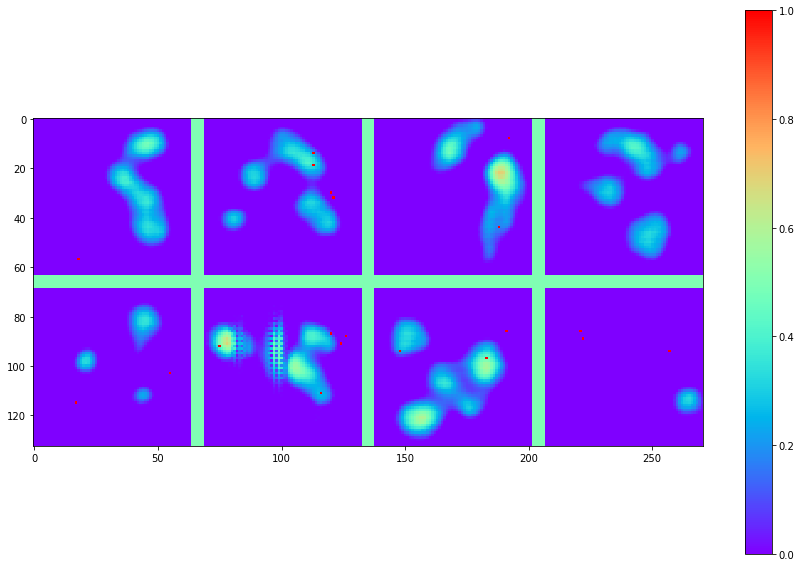

In [ ]:
print(len(img_list))
fig1  = plt.figure(1, figsize = (15, 10) )
voir_batch2D(img_list[-1] + (fixed_y>0).float().cpu(), 4, fig1, k=0, min_scale=0,max_scale=1)


Au bout de quelques époques:
- les disques sont encore mal individualisés.
- la condition ne semble pas prise en compte (ici, les points rouges sont des mesures strictement positives. Le réseau aurait dû générer des disques à leur endroit).
- des figures en damier apparaissent: elles sont typiques d'un UNet qui n'a pas été correctement entraîné.

**Q6** Pour obtenir un GAN qui tienne compte de la condition contenue dans les $y_i$, il est nécessaire de pousser l'apprentissage plus loin. Le fichier *data/netG_180ep_WGP_scheduler75_lr005.pt* contient les poids obtenus après apprentissage sur 300 époques.
Charger ces poids et visualiser plusieurs images pour les mêmes entrée $x_i$ et $z_i$. Vérifier la cohérence et conclure.

In [ ]:
print(netG)

In [ ]:
weights = torch.load('../data/netG_180ep_WGP_scheduler75_lr005.pt')
print(weights.keys())
netG.load_state_dict(weights['model_state_dict'])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


<All keys matched successfully>

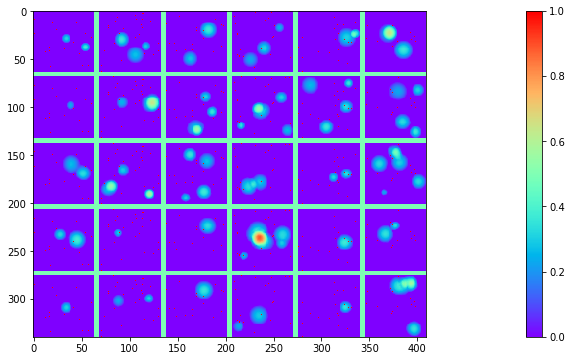

In [ ]:
netG.eval()

x , y , z = gen_condDCGAN(6, p = dens_obs)

# Generate fake image batch with G
real_and_fakes = [x + 1 * (y>=0).float()]
real = x + 1 * (y>=0).float()
fakes = []

n = 4
for i in range(n):
    _ , _ , z = gen_condDCGAN(6, p = dens_obs)
    yz = torch.cat((y,z),dim=1).cuda()
    with torch.no_grad():
        fake = netG(yz).cpu() + 1 * (y>=0).float()
    fakes.append(fake)

fakes = torch.cat(fakes,dim=0)
real_and_fakes = torch.cat((real,fakes),dim=0)

# Ligne 1 : des images réelles avec les points de mesures (y) du champ x
# Ligne 2-5 : des images générées
fig1 = plt.figure(4, figsize=(36, 6))
voir_batch2D(real_and_fakes, 6, fig1, k=0, min_scale=0, max_scale=1)

In [ ]:
x , y , z = gen_condDCGAN(128, p = dens_obs)

n = 128
real_on_sensors_strictpos = []
diff_fake_on_sensors_strictpos = []
diff_fake_on_sensors_nulls = []
real_on_sensors = []
diff_fake_on_sensors = []

for i in range(n):
    _ , _ , z = gen_condDCGAN(128, p = dens_obs)
    yz = torch.cat((y,z),dim=1).cuda()
    with torch.no_grad():
        fake = netG(yz).cpu()
        real_on_sensors_strictpos.append(y[y>0])
        diff_fake_on_sensors_strictpos.append(np.abs(fake[y>0] - y[y>0]))
        diff_fake_on_sensors_nulls.append(np.abs(fake[y == 0] - y[y == 0]))
        real_on_sensors.append(y[y >= 0])
        diff_fake_on_sensors.append(np.abs(fake[y >= 0] - y[y >= 0]))


In [ ]:
print('moyenne des mesures str. positives')
print(torch.cat(real_on_sensors_strictpos, dim=0).mean())
print('écart real-fake aux points de mesures str. positives')
print(torch.cat(diff_fake_on_sensors_strictpos, dim=0).mean())
print('écart real-fake aux points de mesures nulles')
print(torch.cat(diff_fake_on_sensors_nulls, dim=0).mean())

print('moyenne des mesures disponibles dans y')
print(torch.cat(real_on_sensors, dim=0).mean())
print('écart real-fake aux points de mesures')
print(torch.cat(diff_fake_on_sensors, dim=0).mean())

moyenne des mesures str. positives
tensor(0.2038)
écart real-fake aux points de mesures str. positives
tensor(0.0485)
écart real-fake aux points de mesures nulles
tensor(0.0048)
moyenne des mesures disponibles dans y
tensor(0.0319)
écart real-fake aux points de mesures
tensor(0.0116)


Au plan qualitatif, les disques générés ressemblent aux disques originaux. En particulier, les zones de coalescence entre les disques sont assez bien rendues.\
De plus, ces disques semblent cohérents avec la valeur des mesures ponctuelles et semblent correctement échantillonner la loi conditionnelle:
- il n'y a (très généralement) pas de disque lorsque la valeur est nulle.
- il y a (très généralement) un disque là où la valeur mesurée est non-nulle.

Enfin, la densité conditionnelle semble correctement échantillonnée (diversité des formes et des rayons).

Au plan quantitatif, on peut très rapidement comparer la valeur des images générées aux points de mesures avec les mesures elles-mêmes (deuxième cellule et troisème cellule au-dessus).
L'écart représente 1/3 de la valeur moyenne.

La cellule au-dessus permet même de préciser: lorsque la mesure est nulle, la valeur générée correspondante est faible (en moyenne 0.005), mais l'écart est nettement plus grand lorsque la mesure est nion nulle (environ 0.05, soit 20% de la valeur moyenne).

Le résultat est donc encore imparfait.